In [61]:
import os
import numpy as np
import tensorflow as tf
from typing import Sequence, Optional, Union
import math
import helpers.input_processor as ip
import polars as pl
import matplotlib.pyplot as plt
import librosa
import tensorflow_io as tfio
import copy

In [62]:
def balanceData(df, byColumn, method):
    # balance a copy of df to avoid modifying df directly
    _df = df.clone()
    # Assume the column being sorted contains only two different values
    values = _df.get_column(byColumn).unique().to_list()
    val1, val2 = values[0], values[1]
    # Split dataset into two subsets by value in the specified column
    subset1 = _df.filter(pl.col(byColumn)==val1)
    subset2 = _df.filter(pl.col(byColumn)==val2)
    # Count the number of rows in df that contain val1 and the number of rows that contain val2
    count = lambda dataframe, val: dataframe.filter(pl.col(byColumn)==val).height
    size1 = count(_df, val1)
    size2 = count(_df, val2)

    if method=='grow':
        # Balance data by duplicating random rows of whichever subset is smaller
        while size1!=size2:
            if size1<size2:
                _df = _df.vstack(subset1.sample(n=min(size2-size1, subset1.height)))
            else:
                _df = _df.vstack(subset2.sample(n=min(size1-size2, subset2.height)))
            size1 = count(_df, val1)
            size2 = count(_df, val2)
    elif method=='truncate':
        # Balance data by filtering out rows of whichever group is larger
        if size1<size2:
            _df = subset1.vstack(subset2.sample(n=size1))
        elif size2<size1:
            _df = subset2.vstack(subset1.sample(n=size2))
        else:
            _df = subset1.vstack(subset2)
    else:
        raise Exception(f'method expected \'grow\' or \'truncate\', but received {method}')

    # Shuffle and return balanced df
    _df = _df.sample(frac=1., shuffle=True)
    assert count(_df, val1)==count(_df, val2)
    return _df


def paddedTrim(audio, duration, sr):
    originalLength = tf.size(audio)
    trimmedLength = tf.cast(tf.math.floor(duration*sr), tf.int32)
    # Define the range of possible indices where the slice window may start
    startBounds = tf.sort(tf.stack([originalLength-trimmedLength, tf.constant(0)], 0))
    print(startBounds)
    # Pad audio on both sides to the outer possible boundary of the slice window
    padSize = tf.math.abs(startBounds[0])
    paddedAudio = tf.pad(audio, paddings=[[padSize, padSize]])
    # Get a random starting point for the slice window relative to the unpadded audio
    startBounds = tf.cast(startBounds, tf.float32)
    unpaddedStart = tf.math.round(tf.random.uniform(shape=[1], minval=startBounds[0], maxval=startBounds[1]))
    # Slice the audio
    paddedStart = tf.cast(unpaddedStart + tf.cast(padSize, tf.float32), tf.int32)
    shape = tf.reshape(trimmedLength, [1])
    trimmedAudio = tf.slice(paddedAudio, paddedStart, shape)
    return trimmedAudio


def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

In [63]:
class input(object):
    def __init__(self, filePaths:Sequence[str], labels:Sequence[float], startTimes:Optional[Sequence[float]]=None, endTimes:Optional[Sequence[float]]=None, batchSize:Optional[int]=None, duration:Union[float,str]=10, sr:int=4000, augmentData:bool=False):
        # Validate inputs
        self.__validate(filePaths, labels, startTimes, endTimes, batchSize, duration, sr, augmentData)

        _filePaths = filePaths
        _labels = labels
        _startTimes = startTimes if startTimes is not None else [None]*len(filePaths)
        _endTimes = endTimes if endTimes is not None else [None]*len(filePaths)

        self.totalSize = len(filePaths)
        self.batchSize = batchSize
        self.numBatches = math.floor(self.totalSize / batchSize) if batchSize is not None else 0
        self.sr = sr
        self.duration = float(duration)
        self.augmentData = augmentData
        self.dataset = self.__getDataset(_filePaths, _labels, _startTimes, _endTimes)

    @classmethod
    def fromPolars(cls, df:pl.DataFrame, batchSize:Optional[int]=None, duration:Union[float,str]=10, sr:int=4000, augmentData:bool=False):
        f'''Creates an instance of class {cls.__name__} from a polars DataFrame.'''
        for col in ['filePaths', 'labels', 'startTimes', 'endTimes']:
            if col not in df.columns:
                raise Exception(f'Column \'{col}\' not found in dataframe with colums {df.columns}')
        return cls(
            filePaths=df.get_column('filePaths').to_list(),
            labels=df.get_column('labels').to_list(),
            startTimes=df.get_column('startTimes').to_list(),
            endTimes=df.get_column('endTimes').to_list(),
            batchSize=batchSize,
            duration=duration,
            sr=sr,
            augmentData=augmentData
        )

    @staticmethod
    def __validate(filePaths, labels, startTimes, endTimes, batchSize, duration, sr, augmentData):
        '''Validates the inputs to the constructor'''
        # Check that data has consistent shape
        cols = [filePaths, labels, startTimes, endTimes]
        if any(len(col)!=len(cols[0]) for col in cols if col is not None):
            raise Exception(f'Expected lists with equal length, but received lists with lengths {[len(col) for col in cols if col is not None]}')
        # Check that startTime and endTime are either both specified or both unspecified (assuming both are either a sequence of float or None)
        if type(startTimes)!=type(endTimes):
            raise Exception(f'startTimes and endTimes must either both have type Sequence[float] or both be None, but received startTimes with type {type(startTimes)} and endTimes with type {type(endTimes)}.')
        # Check that batch size is not larger than the total amount of data
        if batchSize is not None and batchSize > len(filePaths):
            raise Exception(f'batchSize={batchSize} cannot be larger than the length of filePaths')

    def __getDataset(self, filePaths, labels, startTimes, endTimes) -> tf.data.Dataset:
        datasetCols = (filePaths, labels, startTimes, endTimes)
        dataset = (
            tf.data.Dataset.from_tensor_slices(datasetCols)
            .map(self._preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
        )
        return dataset

    def _preprocessor(self, filePath, label, startTime, endTime):
        sr = tf.constant(self.sr, dtype=tf.float32)

        # Load and decode audio file
        encodedAudio = tf.io.read_file(filePath)
        rawAudio, _ = tf.audio.decode_wav(encodedAudio)
        rawAudio = tf.squeeze(rawAudio)

        # If specified, extract the sample from the audio file using startTime and endTime.
        # Otherwise, use the entire audio file as the sample.
        if startTime is None or endTime is None:
            audio = rawAudio
        else:
            startInd = tf.cast(tf.math.floor((startTime*sr)), tf.int32)
            endInd = tf.cast(tf.math.floor((endTime*sr)), tf.int32)
            audio = rawAudio[startInd:endInd]

        # Resize samples to uniform length, either by padding it with silence or truncating it
        trimmedAudio = paddedTrim(audio, self.duration, sr)

        # Time shift signal to the left or right by a random percent of its original length (max 99%)
        #   NOT IMPLEMENTED 

        # # Convert audio signal to mel spectrogram
        # spec = tf.signal.stft(trimmedAudio, frame_length=255, frame_step=128)
        # spec = tf.abs(spec)
        # # melFilterbank = tf.signal.linear_to_mel_weight_matrix(sample_rate=self.sr, upper_edge_hertz=1900) #NOT DONE
        # # melSpec = tf.matmul(spec, melFilterbank)
        # # melSpec = power_to_db(melSpec)

        # melSpec = spec

        # # Apply time and frequency masking
        # #   NOT IMPLEMENTED


        # TODO: ADJUST HYPERPARAMS, MAKE SURE AUDIO INPUT IS IN CORRECT ORIENTATION
        # SO THAT TIME IS ON THE X AXIS.
        spec = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=256)
        melSpec = tfio.audio.melscale(spec, rate=self.sr, mels=128, fmin=0, fmax=self.sr/2)
        melSpec = tfio.audio.dbscale(melSpec, top_db=80)

        sampleOut = melSpec[..., tf.newaxis]
        labelOut = label
        return sampleOut, labelOut

    def describe(self):
        printout = {
            'Total Size': self.totalSize,
            'Batch Size': self.batchSize,
            'Number of Batches': self.numBatches,
            'Duration (s)': self.duration,
            'Perform data augmentation': self.augmentData
        }
        for key, value in printout.items():
            print(f'{key}: {value}')
            



In [64]:
BATCH_SIZE = 64
NUM_EPOCHS = 50
H = 256
W = 313
DEVICE = 'gpu'

segmentAudio = False

# Load data from dataframe
data_dir = "data/raw_training/training_data/"
df = (
    ip.loadTrainingData(data_dir)
    .filter(pl.col('murmur_in_recording') != 'Unknown')
    .pipe(ip.encodeData)
    .select([
        pl.col('audio_file').apply(lambda x: os.path.join(data_dir, x)).alias('filePaths'),
        pl.col('murmur_in_recording').alias('labels'),
        pl.col('segments')
    ])
)
# Get the start and end time of each sample
if segmentAudio==True:
    df = (
        # Reshape df so that each segment is on its own line
        df.explode('segments').rename({'segments':'segment'})
        # Reformat segment to a list containing the start and end time of the segment as a float
        .with_column(pl.col('segment').str.strip().str.split(by='+').arr.eval(pl.element().cast(pl.Float32)))
        # Replace the segment column with two new columns containing the start and end time of the segment
        .with_columns([
            pl.col('segment').arr.get(0).alias('startTimes'),
            pl.col('segment').arr.get(1).alias('endTimes')
        ])
        .drop('segment')
    )
else:
    df = (
        df.with_columns([
            pl.Series('startTimes', [None]*df.height),
            pl.Series('endTimes', [None]*df.height)
        ])
        .drop('segments')
    )

# Shuffle data
df = df.sample(frac=1.0, shuffle=True)

# Split data into training, validation, and testing sets
train_df, test_df = ip.splitDataframe(df, split_ratio=0.9)
train_df, val_df = ip.splitDataframe(train_df, split_ratio=0.8)

# Balance data so there is an equal number of murmur present and murmur absent samples
train_df = balanceData(train_df, 'labels', 'grow')
val_df = balanceData(val_df, 'labels', 'grow')
test_df = balanceData(test_df, 'labels', 'grow')

# check that sets are unique
for set1, set2 in [[train_df, val_df], [train_df, test_df], [val_df, test_df]]:
    col1 = set1.select(pl.concat_str([pl.col(['filePaths', 'labels'])], sep="\t\t").alias('set1Cols')).get_column('set1Cols')
    col2 = set2.select(pl.concat_str([pl.col(['filePaths', 'labels'])], sep="\t\t").alias('set2Cols')).get_column('set2Cols')
    overlap = col1.is_in(col2)
    if overlap.any():
        print(col1.len(), col2.len())
        print(overlap.value_counts())
        problem = col1.filter(overlap)
        raise Exception(
            'Training, validation, and/or testing sets are not unique.' +
            f' Number of overlaps: {col1.filter(overlap).len()}'
        )
    else:
        print('Datasets are unique')

loading data from save file:  cache/ingested_data.json
Datasets are unique
Datasets are unique
Datasets are unique


In [65]:
train = input.fromPolars(train_df, batchSize=BATCH_SIZE, duration=1)
train.describe()




Tensor("sort/sub_1:0", shape=(2,), dtype=int32)
Total Size: 3582
Batch Size: 64
Number of Batches: 55
Duration (s): 1.0
Perform data augmentation: False


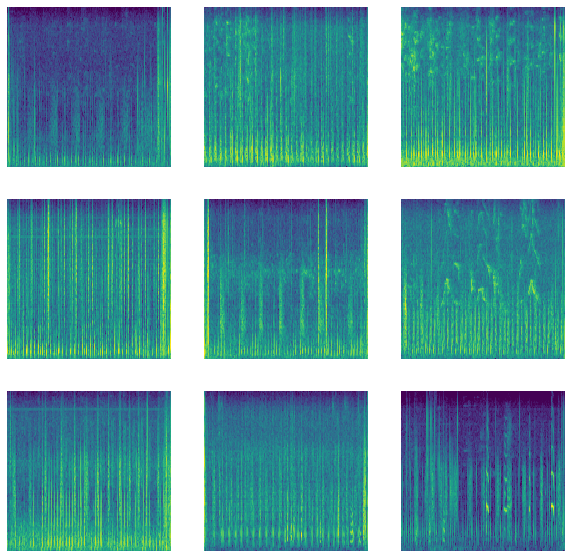

In [66]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # transpose, so that the time is
  # represented on the x-axis (columns).
  spectrogram = spectrogram.T
  height = spectrogram.shape[0]
  width = spectrogram.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, spectrogram)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(train.dataset.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.axis('off')

plt.show()
